In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append('/Users/joewandy/work/git/vimms')
sys.path.append('/Users/joewa/work/git/vimms')
sys.path.append('/home/joewandy/vimms')

In [3]:
from os.path import exists
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from vimms.Common import load_obj, save_obj, create_if_not_exist

In [4]:
from vimms.scripts.DDA_vs_DIA import compare_spectra, spectral_distribution, pairwise_spectral_distribution, \
    spec_records_to_library, plot_matching_thresholds, \
    plot_score_distributions, plot_pairwise_similarity, venn_diagram

In [5]:
min_intensity = 25000

In [6]:
clms_home = os.path.abspath('real_data_analysis_%d' % min_intensity)
base_folder = os.path.join(clms_home, 'fragmentation_files')
output_folder = os.path.abspath('DDA_vs_DIA_real_similiarity_intensity_non_overlap_%d' % min_intensity)
create_if_not_exist(output_folder)

In [7]:
matching_thresholds = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# matching_thresholds = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

matching_method = 'cosine'
matching_ms1_tol = 1
matching_ms2_tol = 0.05
matching_min_match_peaks = 3

gnps_file = os.path.join(clms_home, 'msp', 'GNPS-NIST14-MATCHES.mgf')

methods = [
    'topN',
    'SWATH',
    'AIF'
]

In [8]:
from vimms.scripts.check_ms2_matches import make_queries_from_aligned_msdial
from vimms.scripts.DDA_vs_DIA import get_msdial_file, eva_to_matches

pickle_file = os.path.join(output_folder, 'intensity_non_overlap_library.p')
if not exists(pickle_file):

    base_dir = os.path.abspath('real_data_analysis_%d' % min_intensity)
    fullscan_folder = os.path.join(base_dir, 'ground_truth_construction', 'fullscan')
    fullscan_file_name = get_msdial_file(fullscan_folder)
    fullscan_spectra = make_queries_from_aligned_msdial(fullscan_file_name, frag_file=False, sample_name='beer')

    allow_multiple = False
    method = 'intensity_non_overlap'
    msdial_eval_res = {method: load_obj(os.path.join(clms_home, 'intensity_non_overlap_eval_res.p'))}
    matches = eva_to_matches(method, msdial_eval_res, fullscan_spectra, allow_multiple=allow_multiple)
    spectra = [item for sublist in list(matches.values()) for item in sublist]
    
    chem_library = spec_records_to_library(spectra)
    save_obj(chem_library, pickle_file)
    
chem_library = load_obj(pickle_file)
print(len(chem_library.sorted_record_list))

4987


In [9]:
sns.set_context('poster')

# 1. Plot hit proportions across various thresholds

In [10]:
pickle_file = os.path.join(output_folder, 'hit_proportions_df.p')
if not exists(pickle_file):
    hit_prop_df = compare_spectra(chem_library, base_folder, methods, matching_thresholds, 
                                  matching_method, matching_ms1_tol, 
                                  matching_ms2_tol, matching_min_match_peaks)
    hit_prop_df.to_pickle(pickle_file)

In [11]:
hit_prop_df = pd.read_pickle(os.path.join(output_folder, 'hit_proportions_df.p'))
hit_prop_df.head()

,method,matching_threshold,no_annotated_compounds,no_annotated_peaks,prop_annotated_compounds,prop_annotated_peaks,annotated_peaks
0,topN,0.0,4131,2723,0.828354,0.447126,"{peak_439.197810, Unknown, 439.19781, fullscan..."
1,topN,0.1,4112,2720,0.824544,0.446634,"{peak_439.197810, Unknown, 439.19781, fullscan..."
2,topN,0.2,4026,2715,0.807299,0.445813,"{peak_439.197810, Unknown, 439.19781, fullscan..."
3,topN,0.3,3871,2706,0.776218,0.444335,"{peak_439.197810, Unknown, 439.19781, fullscan..."
4,topN,0.4,3699,2691,0.741728,0.441872,"{peak_439.197810, Unknown, 439.19781, fullscan..."


{'AIF': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'SWATH': (1.0, 0.4980392156862745, 0.054901960784313725),
 'topN': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)}

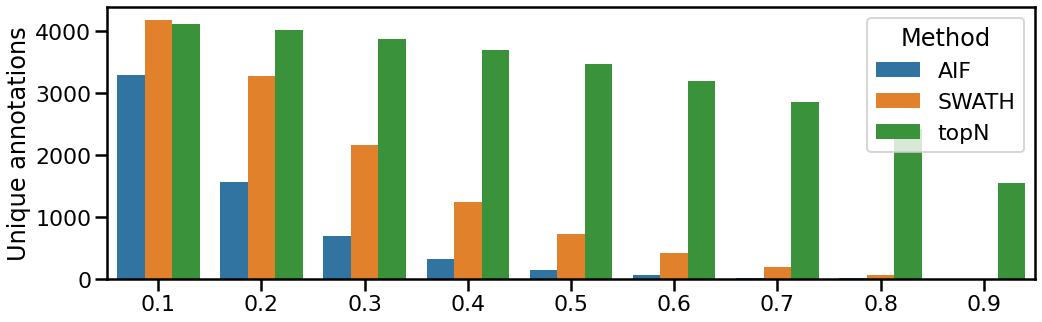

In [12]:
out_file = os.path.join(output_folder, 'hit_proportions.png')
palette = plot_matching_thresholds(hit_prop_df, out_file=out_file)
palette

# 2. Venn diagrams

2443 259 28 2231 47 6


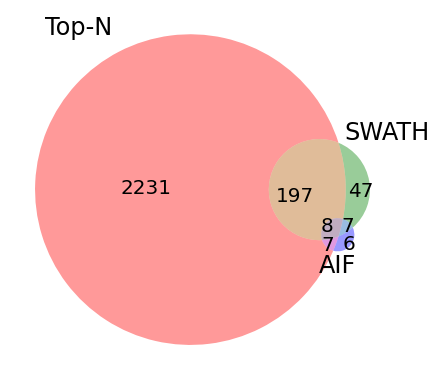

In [26]:
threshold = 0.6
out_file = os.path.join(output_folder, 'venn_diagram.png')
venn_diagram(hit_prop_df, methods, threshold, out_file=out_file)

# 3. Plot Distribution of spectral similarity scores

In [14]:
matching_threshold = 0.0

In [15]:
pickle_file = os.path.join(output_folder, 'score_df.p')
if not exists(pickle_file):
    score_df = spectral_distribution(chem_library, base_folder, methods, matching_threshold, 
                                     matching_method, matching_ms1_tol, 
                                     matching_ms2_tol, matching_min_match_peaks, keep_all=False)  
    score_df.to_pickle(pickle_file)    

In [16]:
score_df = pd.read_pickle(os.path.join(output_folder, 'score_df.p'))
score_df = score_df[score_df['score'] > 0.0]
score_df['score_percent'] = score_df['score'] * 100

In [17]:
score_df.method.unique()

array(['topN', 'SWATH', 'AIF'], dtype=object)

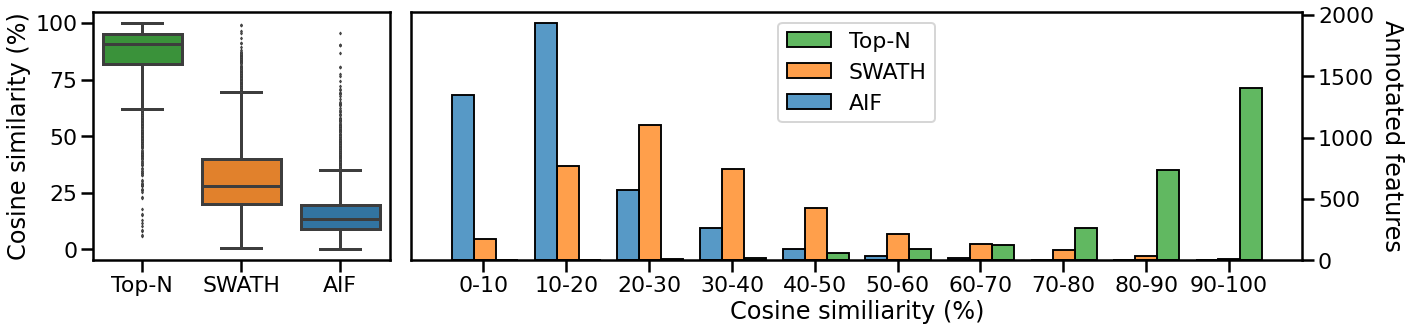

In [18]:
out_file = os.path.join(output_folder, 'score_distributions.png')
_ = plot_score_distributions(score_df, palette=palette, bins=10, out_file=out_file)

In [19]:
score_df.groupby(['method'])['score_percent'].median()

method
AIF      13.272839
SWATH    28.068582
topN     90.517323
Name: score_percent, dtype: float64

# 4. Plot Pairwise Similarity of Spectra

In [20]:
matching_threshold = 0.0

In [21]:
pickle_file = os.path.join(output_folder, 'pairwise_score_df.p')
if not exists(pickle_file):
    pairwise_score_df = pairwise_spectral_distribution(chem_library, base_folder, methods, matching_threshold,
                                                       matching_method, matching_ms1_tol, 
                                                       matching_ms2_tol, matching_min_match_peaks)
    pairwise_score_df.to_pickle(pickle_file)    

In [22]:
pairwise_score_df = pd.read_pickle(os.path.join(output_folder, 'pairwise_score_df.p'))
pairwise_score_df.shape

(279095, 3)

In [23]:
pairwise_score_df

,method,spectrum_id,score
0,ground_truth,peak_70.065315,0.000000
1,ground_truth,peak_70.065331,0.000000
2,ground_truth,peak_70.065399,0.000000
3,ground_truth,peak_70.067169,0.000000
4,ground_truth,peak_70.070488,0.000000
...,...,...,...
279090,AIF,peak_847.290220,0.466710
279091,AIF,peak_847.290220,0.466710
279092,AIF,peak_846.306150,0.466710
279093,AIF,peak_901.477230,0.537749


[Text(0, 0, 'ground_truth'),
 Text(1, 0, 'topN'),
 Text(2, 0, 'SWATH'),
 Text(3, 0, 'AIF')]

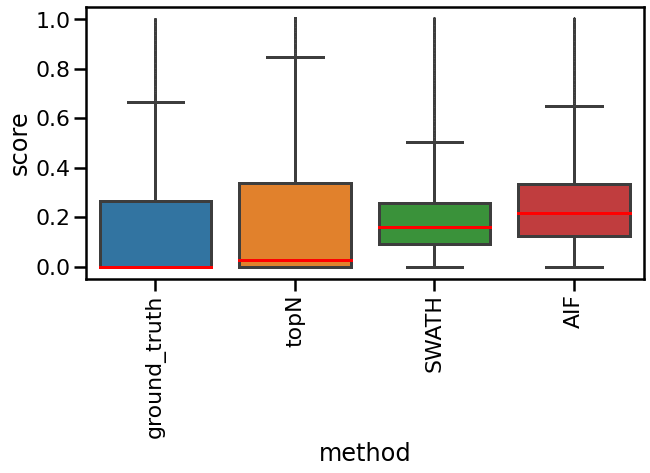

In [24]:
plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=pairwise_score_df, x='method', y='score', showfliers=True, 
                 medianprops={'color': 'red', 'lw': 3}, flierprops = dict(markerfacecolor = '0.50', markersize = 2))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

{'AIF': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'SWATH': (1.0, 0.4980392156862745, 0.054901960784313725),
 'topN': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'ground_truth': (0.17254901960784313,
  0.6274509803921569,
  0.17254901960784313),
 'ref_spec_gnps': 'white',
 'ref_spec_intensity': 'white'}

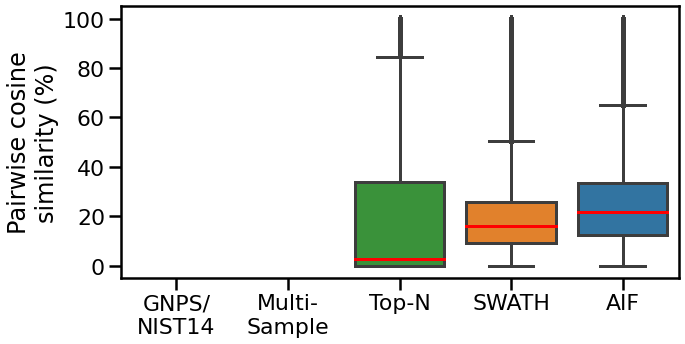

In [25]:
out_file = os.path.join(output_folder, 'pairwise_similarity.png')
plot_pairwise_similarity(pairwise_score_df, palette=palette, out_file=out_file)